# Notebook to train and evaluate our cnn

* We use this notebook to help us create ML model to classify the visibility
* We experiment with two approaches
    * A training pipeline that assumes a balanced training set
    * A training pipeline that performed upsabmling of an imbalanced datasret
        * We make sure that training data are not part of the validation data in the upsambling mechanism
    * User should execute the associated cells for each method of dataset preparation
* We provide training metrics as well as goodness metrics of the model after training
* We save the model in a destination artifact folder - user should set the path
* Sanity tests are provided where the user runs cells to load the ML models and do inference on images

In [1]:
from matplotlib import pyplot as plt
# import the necessary packages
import sys
# sys.path.append('/Users/antonios.ntelidakis/Documents/dev/keras_grayscale_idpose_custom')
sys.path.append('../code/')
from nn.customvggnet import ACustomVGGNet, feature_engineer_to_train
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
#from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os
import csv

In [2]:
data = []
labels = []
img_size = 64
depth = 1
project_dir = '/Users/antonios.ntelidakis/Documents/dev/dlcv_id_challenge'
model_dir_name = 'idvggnet_upsampling/'
output_dir = project_dir + '/artifacts/' + model_dir_name

In [3]:
print(output_dir)

/Users/antonios.ntelidakis/Documents/dev/dlcv_id_challenge/artifacts/idvggnet_upsampling/


## Run this bit for Upsampling Training Data approach: 
* Load csv, get annotations, split train/test by class type in different lists
* Upsamble each train/test list to match the class with the highest number of examples
* There was not time to generalize this approach

In [4]:
csv_dir = '../data/gicsd_labels.csv'
base_data_dir = os.path.dirname(csv_dir)
path_imgs_full_vis = []
path_imgs_partial_vis = []
path_imgs_no_vis = []
test_size=0.25
# labels_full_vis = []
# labels_partial_vis = []
# labels_no_vis = []
with open(csv_dir, newline='') as csvfile:
    labelreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(labelreader)
    for row in labelreader:
        src = base_data_dir+'/images/'+row[0]
        cur_label = row[1].strip()
        if cur_label == 'NO_VISIBILITY':
            path_imgs_no_vis.append(src)
        elif cur_label == 'PARTIAL_VISIBILITY':
            path_imgs_partial_vis.append(src)
        elif cur_label == 'FULL_VISIBILITY':
            path_imgs_full_vis.append(src)
# labels_full_vis = ['FULL_VISIBILITY'] * len(path_imgs_full_vis)
# labels_partial_vis = ['PARTIAL_VISIBILITY'] * len(path_imgs_partial_vis)
# labels_no_vis = ['NO_VISIBILITY'] * len(path_imgs_no_vis)

In [5]:
# print(f'Num examples FULL_VISIBILITY: {len(path_imgs_full_vis)}')
# print(f'Num examples PARTIAL_VISIBILITY: {len(path_imgs_partial_vis)}')
# print(f'Num examples NO_VISIBILITY: {len(path_imgs_no_vis)}')

* Split to train valid test each image path class list independently however using the same split ratio

In [6]:
import random
random.seed(42)
def shuffle_and_partition_train_test(raw, test_percent):
    howManyNumbers = int(round(test_percent*len(raw)))
    shuffled = raw[:]
    random.shuffle(shuffled)
    return shuffled[howManyNumbers:], shuffled[:howManyNumbers]

In [7]:
path_full_vis_train, path_full_vis_test = shuffle_and_partition_train_test(path_imgs_full_vis, test_size)
path_partial_vis_train, path_partial_vis_test = shuffle_and_partition_train_test(path_imgs_partial_vis, test_size)
path_no_vis_train, path_no_vis_test = shuffle_and_partition_train_test(path_imgs_no_vis, test_size)

In [8]:
path_no_vis_test[1]

'../data/images/GICSD_20_7_213.png'

In [9]:
print(f'Full. n_train: {len(path_full_vis_train)}, n_test: {len(path_full_vis_test)}, tota: {len(path_imgs_full_vis)}')
print(f'Partial. n_train: {len(path_partial_vis_train)}, n_test: {len(path_partial_vis_test)}, tota: {len(path_imgs_partial_vis)}')
print(f'No. n_train: {len(path_no_vis_train)}, n_test: {len(path_no_vis_test)}, tota: {len(path_imgs_no_vis)}')

Full. n_train: 484, n_test: 162, tota: 646
Partial. n_train: 92, n_test: 31, tota: 123
No. n_train: 23, n_test: 8, tota: 31


In [10]:
# print((len(path_full_vis_train)+len(path_full_vis_test)) == len(path_imgs_full_vis))
# print((len(path_partial_vis_train)+len(path_partial_vis_test)) == len(path_imgs_partial_vis))
# print((len(path_no_vis_train)+len(path_no_vis_test)) == len(path_imgs_no_vis))

* Find class with max number of train, test examples, and use that number to repeat/ upsamble train, test data

In [11]:
max_train = max(len(path_full_vis_train), len(path_partial_vis_train), len(path_no_vis_train))
max_test = max(len(path_full_vis_test), len(path_partial_vis_test), len(path_no_vis_test))
print(f'Max Train: {max_train}, Max Test: {max_test}')

Max Train: 484, Max Test: 162


* Upsamble path Data

In [12]:
from itertools import cycle, islice
# lst = [1, 2, 3]
# list(islice(cycle(lst), 7))

In [13]:
path_full_vis_train = list(islice(cycle(path_full_vis_train), max_train))
path_partial_vis_train = list(islice(cycle(path_partial_vis_train), max_train))
path_no_vis_train = list(islice(cycle(path_no_vis_train), max_train))

path_full_vis_test = list(islice(cycle(path_full_vis_test), max_test))
path_partial_vis_test = list(islice(cycle(path_partial_vis_test), max_test))
path_no_vis_test = list(islice(cycle(path_no_vis_test), max_test))

In [14]:
# print(len(path_full_vis_train))
# print(len(path_partial_vis_train))
# print(len(path_no_vis_train))
# print(len(path_full_vis_test))
# print(len(path_partial_vis_test))
# print(len(path_no_vis_test))

* Load actual train and test data upsambled in a format ready training

In [15]:
tota_path_train = path_full_vis_train + path_partial_vis_train + path_no_vis_train
trainX = []
trainY = ['FULL_VISIBILITY']*max_train + ['PARTIAL_VISIBILITY']*max_train + ['NO_VISIBILITY']*max_train
for img_path in tota_path_train:
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img_trainready = feature_engineer_to_train(img)
    trainX.append(img_trainready)    
trainX = np.array(trainX, dtype="float")
trainY = np.array(trainY)

In [16]:
print(trainX.shape)
print(trainY.shape)

(1452, 64, 64, 1)
(1452,)


In [17]:
tota_path_test = path_full_vis_test + path_partial_vis_test + path_no_vis_test
testX = []
testY = ['FULL_VISIBILITY']*max_test + ['PARTIAL_VISIBILITY']*max_test + ['NO_VISIBILITY']*max_test
for img_path in tota_path_test:
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img_trainready = feature_engineer_to_train(img)
    testX.append(img_trainready)  
testX = np.array(testX, dtype="float")
testY = np.array(testY)
print(testX.shape)
print(testY.shape)

(486, 64, 64, 1)
(486,)


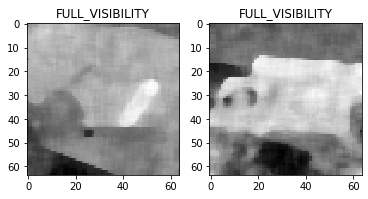

In [18]:
plt.subplot(121),plt.imshow(trainX[0].reshape(trainX.shape[1],trainX.shape[2]), cmap='gray')
plt.title(trainY[0])
plt.subplot(122),plt.imshow(testX[0].reshape(testX.shape[1],testX.shape[2]), cmap='gray')
plt.title(testY[0])
plt.show()

* Finally do an additional shuffling of the train/test data/label pairs

In [19]:
indices = np.arange(trainX.shape[0])
np.random.shuffle(indices)
trainX = trainX[indices]
trainY = trainY[indices]
print(trainX.shape)
print(trainY.shape)
indices = np.arange(testX.shape[0])
np.random.shuffle(indices)
testX = testX[indices]
testY = testY[indices]
print(testX.shape)
print(testY.shape)

(1452, 64, 64, 1)
(1452,)
(486, 64, 64, 1)
(486,)


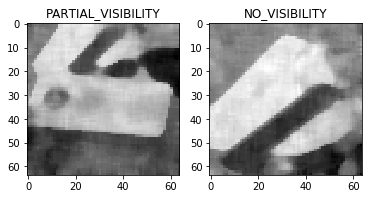

In [20]:
plt.subplot(121),plt.imshow(trainX[0].reshape(trainX.shape[1],trainX.shape[2]), cmap='gray')
plt.title(trainY[0])
plt.subplot(122),plt.imshow(testX[0].reshape(testX.shape[1],testX.shape[2]), cmap='gray')
plt.title(testY[0])
plt.show()

In [ ]:
# train_zip_shuffle = list(zip(trainX, trainY))
# random.shuffle(train_zip_shuffle)
# trainX, trainY = zip(*train_zip_shuffle)

# test_zip_shuffle = list(zip(testX,testY))
# random.shuffle(test_zip_shuffle)
# testX, testY = zip(*test_zip_shuffle)

In [ ]:
# a = ['a', 'b', 'c']
# b = [1, 2, 3]
# print(type(a))
# c = list(zip(a, b))
# random.shuffle(c)
# a, b = zip(*c)
# print(type(a))
# print(a)
# print(b)

In [ ]:
# import numpy as np
# a = np.array([0,1,2,3,4])
# b = np.array([5,6,7,8,9])

# indices = np.arange(a.shape[0])
# np.random.shuffle(indices)

# a = a[indices]
# b = b[indices]

## Run this bit for balanced Training Data generation: Load csv, get annotations, do normal pipeline

In [ ]:
csv_dir = '/Users/antonios.ntelidakis/Documents/personal/revolut/Computer vision HT/data/gicsd_labels.csv'
base_data_dir = os.path.dirname(csv_dir)
data = []
labels = []
with open(csv_dir, newline='') as csvfile:
    labelreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(labelreader)
    for row in labelreader:
        img_path = base_data_dir+'/images/'+row[0]
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img_trainready = feature_engineer_to_train(img)
        data.append(img_trainready)
        cur_label = row[1].strip()
        labels.append(cur_label)

In [ ]:
data = np.array(data, dtype="float")
labels = np.array(labels)

In [ ]:
data.shape

In [ ]:
data[0].shape

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

## Run This Bit to create a model and start training

In [21]:
# convert the labels from integers to vectors 
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [22]:
trainY.shape

(1452, 3)

In [23]:
lb.classes_

array(['FULL_VISIBILITY', 'NO_VISIBILITY', 'PARTIAL_VISIBILITY'],
      dtype='<U18')

* Should probably remove zoom, width and height shift as this may crop edge cases of fully visible images.
* Should train a few nns to see if we get better result

In [24]:
# aug = ImageDataGenerator(rotation_range=30, shear_range=0.2, zoom_range=0.2, 
#                          horizontal_flip=True, fill_mode="nearest")

aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [25]:
# initialize our VGG-like Convolutional Neural Network
model = ACustomVGGNet.build(width=img_size, height=img_size, depth=depth, classes=len(lb.classes_))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

In [27]:
# initialize our initial learning rate, num of epochs (how many times we see all train examples) to train for,
# and batch size 
INIT_LR = 0.01
EPOCHS = 75 # 2 # 75
BS = 32

In [28]:
# initialize the model and optimizer (you'll want to use
# binary_crossentropy for 2-class classification)
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [29]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS)

[INFO] training network...
Epoch 1/3
45/45 [==============================] - 40s 895ms/step - loss: 1.4292 - accuracy: 0.5028 - val_loss: 1.1227 - val_accuracy: 0.3333
Epoch 2/3
45/45 [==============================] - 42s 939ms/step - loss: 1.1567 - accuracy: 0.5690 - val_loss: 1.2298 - val_accuracy: 0.3333
Epoch 3/3
45/45 [==============================] - 43s 959ms/step - loss: 0.9000 - accuracy: 0.6556 - val_loss: 1.1352 - val_accuracy: 0.3333


In [30]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
                    precision    recall  f1-score   support

   FULL_VISIBILITY       0.00      0.00      0.00       162
     NO_VISIBILITY       0.33      1.00      0.50       162
PARTIAL_VISIBILITY       0.00      0.00      0.00       162

          accuracy                           0.33       486
         macro avg       0.11      0.33      0.17       486
      weighted avg       0.11      0.33      0.17       486



/Users/antonios.ntelidakis/miniconda/envs/ds_env2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
testY.shape

(486, 3)

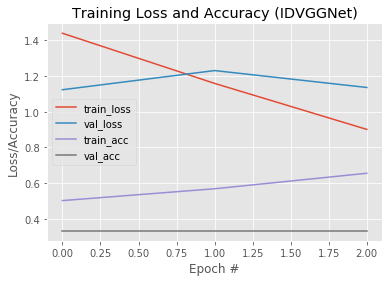

In [32]:
# plot the training loss and accuracy
plot_save_dir = output_dir + 'training_stats.png'
os.makedirs(os.path.dirname(plot_save_dir), exist_ok=True)

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (IDVGGNet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(plot_save_dir)

In [33]:
# save the model and label binarizer to disk
model_save_dir = output_dir 
pickle_labels_save_dir = output_dir + 'idvggnet_lb.pickle'
print(model_save_dir)
print(pickle_labels_save_dir)

/Users/antonios.ntelidakis/Documents/dev/dlcv_id_challenge/artifacts/idvggnet_upsampling/
/Users/antonios.ntelidakis/Documents/dev/dlcv_id_challenge/artifacts/idvggnet_upsampling/idvggnet_lb.pickle


In [34]:
model.save(model_save_dir)
f = open(pickle_labels_save_dir, "wb")
f.write(pickle.dumps(lb))
f.close()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/antonios.ntelidakis/Documents/dev/dlcv_id_challenge/artifacts/idvggnet_upsampling/assets


In [ ]:
# model_save_dir = output_dir + 'smallvggnet_upsambled.model' #'smallvggnet.model' #'smallvggnet_upsambled.model' 
# pickle_labels_save_dir = output_dir + 'smallvggnet_lb.pickle'

## Load saved artifarct and do inference on a test image

In [35]:
from tensorflow.keras.models import load_model
# load the model and label binarizer
print("[INFO] loading network and label binarizer...")
model_infer = load_model(model_save_dir)
lb = pickle.loads(open(pickle_labels_save_dir, "rb").read())

[INFO] loading network and label binarizer...


* Load test image and do preprocessing

In [36]:
path_test_image = project_dir + '/data/infer_test_images/'
img_file_NO_VISIBILITY = path_test_image + 'GICSD_20_7_213.png' #'NO_VISIBILITY_GICSD_8_7_213.png'
img_file_PARTIAL_VISIBILITY = path_test_image + 'GICSD_32_6_193.png'#'PARTIAL_VISIBILITY_GICSD_39_6_193.png'
img_file_FULL_VISIBILITY = path_test_image + 'GICSD_11_1_33.png' # FULL_VISIBILITY_GICSD_1_4_133.png' 
img_file = img_file_FULL_VISIBILITY#path_test_image + 'FULL_VISIBILITY_GICSD_1_4_133.png' 
# img_file = path_test_image + 'partial_visibility.png' #'no_visibility.png' #'partial_visibility.png' #'full_visibility.png'
print(img_file)

/Users/antonios.ntelidakis/Documents/dev/dlcv_id_challenge/data/infer_test_images/GICSD_11_1_33.png


In [37]:
img_test = cv2.imread(img_file)#cv2.imread(imagePath, cv2.IMREAD_UNCHANGED)
image_processed = feature_engineer_to_train(img_test)

In [38]:
img_test.shape

(192, 192, 3)

In [39]:
print(f'img_test.shape: {img_test.shape}')
print(f'image_processed.shape: {image_processed.shape}')

img_test.shape: (192, 192, 3)
image_processed.shape: (64, 64, 1)


Text(0.5, 1.0, 'Preprocessed Image')

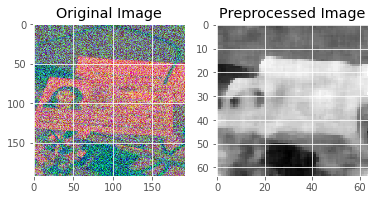

In [40]:
plt.subplot(121),plt.imshow(img_test, cmap='gray')
plt.title('Original Image')
plt.subplot(122),plt.imshow(image_processed.reshape(image_processed.shape[0],image_processed.shape[1]), cmap='gray')
plt.title('Preprocessed Image')

* Reshape image in numpy format to (1, width, height, nchannels) to use keras model for prediciton

In [41]:
image_processed = image_processed.reshape((1, image_processed.shape[0], image_processed.shape[1], image_processed.shape[2]))
image_processed.shape

(1, 64, 64, 1)

In [42]:
# make a prediction on the image
preds = model_infer.predict(image_processed)
# find the class label index with the largest corresponding probability
i = preds.argmax(axis=1)[0]
label = lb.classes_[i]

In [43]:
print(f'class:{label}, prob: {preds[0][i] * 100}')

class:NO_VISIBILITY, prob: 46.318912506103516


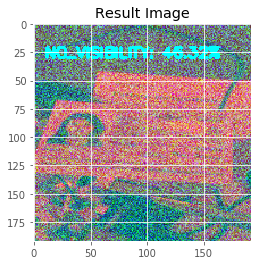

In [44]:
# draw the class label + probability on the output image
text = "{}: {:.2f}%".format(label, preds[0][i] * 100)
output_img = img_test.copy()
cv2.putText(output_img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 255), 2)
plt.subplot(111),plt.imshow(output_img, cmap='gray')
plt.title('Result Image')
plt.show()